In [5]:
# S_00168901 S_00170101 S_00170601 S_00181401 S_00183004 S_02622401 S_01294501 S_00519201 S_01389101
PRODUCT_ID = "S_01389101"

In [6]:
c_speed = 299792458 # 光速, m/s
sample_interval = 0.0375 # 微秒
range_interval = c_speed * sample_interval / 2 / 1e6 # m
range_interval

5.621108587499999

In [7]:
import numpy as np
import pdr
from method.download_method import download_with_requests
from pathlib import Path
from tqdm import tqdm
import os

# 画图
def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img

PRODUCT_ID_PREFIX = PRODUCT_ID[:6] + "XX"
url_prefix = "https://pds-geosciences.wustl.edu/mro/mro-m-sharad-5-radargram-v2/mrosh_2101/"
geom_lbl_url = url_prefix + "DATA/GEOM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_GEOM.LBL"
geom_table_url = url_prefix + "DATA/GEOM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_GEOM.TAB"
rdr_lbl_url = url_prefix + "DATA/RGRAM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_RGRAM.LBL"
rdr_img_url = url_prefix + "DATA/RGRAM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_RGRAM.IMG"
save_path = r"E:\PycharmProjects\mars_sim_web\method\sharad_sim\data\RDR\rdr_data"
urls = [geom_lbl_url, geom_table_url, rdr_lbl_url, rdr_img_url]
filenames = [Path(url).name for url in urls]
download_with_requests(urls, filenames, save_path, overwrite=False)

所有文件已经存在。


In [8]:
from method.sharad_sim.simmulation import *
# result的位置
result_path = r"E:\PycharmProjects\mars_sim_web\method\sharad_sim\data\result"
result_path = os.path.join(result_path, PRODUCT_ID)
# 读取rgram
rgram = np.load(os.path.join(result_path, "rgram_data.npy"))
# 读取geom
geom = np.load(os.path.join(result_path, "geom_data.npy"),allow_pickle=True)
# 读取sat_lon_lat
sat_lon_lat = np.load(os.path.join(result_path, "sat_lon_lat.npy"))
# 读取sim_area_cartesian
sim_area_cartesian = np.load(os.path.join(result_path, "sim_area_cartesian.npy"))
# 读取sat_radius
sat_radius = np.load(os.path.join(result_path, "sat_radius.npy"))
# 读取delay_index
delay_index = np.load(os.path.join(result_path, "delay_index.npy"))
# 读取area
area = np.load(os.path.join(result_path, "area.npy"))
# 读取incident_angle
incident_angle = np.load(os.path.join(result_path, "incident_angle.npy"))
# 读取point_count
point_count = np.load(os.path.join(result_path, "point_count.npy"))
# 读取delay
delay = np.load(os.path.join(result_path, "delay.npy"))

In [9]:
# # 读取GEOM
# geom = pdr.read(os.path.join(save_path, filenames[0]))
# geom = geom["TABLE"]
# # 调整LONGITUDE的值，使其从0-360变为-180到180之间
# geom.loc[geom["LONGITUDE"] > 180, "LONGITUDE"] -= 360
# # 读取RGRAM
# rgram = pdr.read(os.path.join(save_path, filenames[2]))
# rgram = rgram["IMAGE"]

# 
# sim_area_lonlat, sat_lon_lat, point_count, sat_radius = get_sim_area_lonlat(
#     geom
# )
# sim_area_cartesian = get_sim_area_cartesian(sim_area_lonlat, point_count)
# facet_index = cal_facet_idx()
# center_point = cal_center_point(sim_area_cartesian, facet_index, point_count)
# normal_vector, area = cal_normal_vector_and_area(
#     geom, sim_area_cartesian, facet_index, sat_lon_lat
# )
# incident_angle, delay, distance = get_incidence_angle_and_delay(
#     sat_lon_lat, center_point, normal_vector, sat_radius
# )
# delay_index = cal_delay_index(delay)
# 星下点是sim_area_cartesian的[:,1500,1,:]，即第1500列的点
sub_star_point = sim_area_cartesian[:, 1500, 1, :]
sat_pos = lonlat_to_cartesian(sat_lon_lat, sat_radius).T
incident_vector = sub_star_point - sat_pos
_distance = np.linalg.norm(incident_vector, axis=1)
relative_height = np.linalg.norm(sat_pos, axis=1)
sub_star_point_delay = 2 * (_distance - relative_height + mars_radius) / velocity_light
# delay_axis是一个以delay_interval为间隔的等差数列，长度为3600，第1800个元素为0
delay_axis = np.linspace(-delay_interval * 1799, delay_interval * 1800, 3600)
delay_axis_min = delay_axis.min()
# delay-时延的最小值，再除以时延间隔，得到时延的索引
sub_star_point_delay_index = (sub_star_point_delay - delay_axis_min) / delay_interval
# 取整
sub_star_point_delay_index = np.int32(np.round(sub_star_point_delay_index))

In [10]:
# # 列出每个星下点的经纬度
# sat_lon_lat

In [11]:
# 读取permittivity，路径method/permittivity/data/permittivity.npy
permittivity = np.load(r"E:\PycharmProjects\mars_sim_web\method\permittivity\data\permittivity.npy")
# 读取对应的经纬度网格坐标method/permittivity/data/lat_axis.npy和method/permittivity/data/lon_axis.npy
lat_axis = np.load(r"E:\PycharmProjects\mars_sim_web\method\permittivity\data\lat_axis.npy")
lon_axis = np.load(r"E:\PycharmProjects\mars_sim_web\method\permittivity\data\lon_axis.npy")
# 确认sat_lon_lat的对应的一系列经纬度在permittivity上最接近的值的索引
sat_lon_lat_index = np.zeros((sat_lon_lat.shape[1], 2), dtype=np.int32)
for i in range(sat_lon_lat.shape[1]):
    sat_lon_lat_index[i, 0] = np.argmin(np.abs(lon_axis - sat_lon_lat[0, i]))
    sat_lon_lat_index[i, 1] = np.argmin(np.abs(lat_axis - sat_lon_lat[1, i]))
# 获取对应的介电常数
sat_permittivity = permittivity[sat_lon_lat_index[:, 1], sat_lon_lat_index[:, 0]]
# sat_permittivity不为nan的个数
print(np.sum(~np.isnan(sat_permittivity)))
print(rgram.shape[1])

2527
4500


In [12]:
# sub_star_point_delay_index

In [13]:
rgram.shape

(3600, 4500)

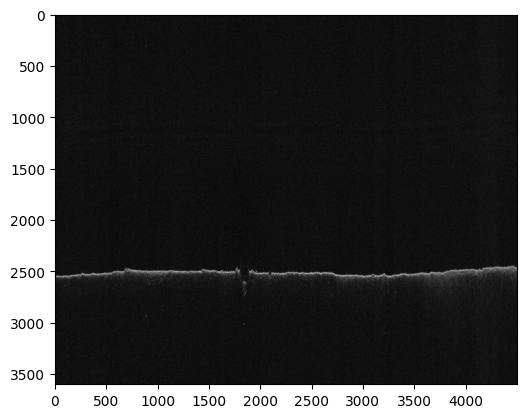

In [14]:
# 画出rgram
import matplotlib.pyplot as plt

plt.imshow(process_img_for_plot(rgram), cmap="gray")

In [15]:
# 对rgram在方位向上进行低通滤波
from scipy.signal import butter, filtfilt

# 低通滤波器
b, a = butter(8, 0.1)
# 对rgram进行滤波
rgram_temp = filtfilt(b, a, rgram, axis=1)

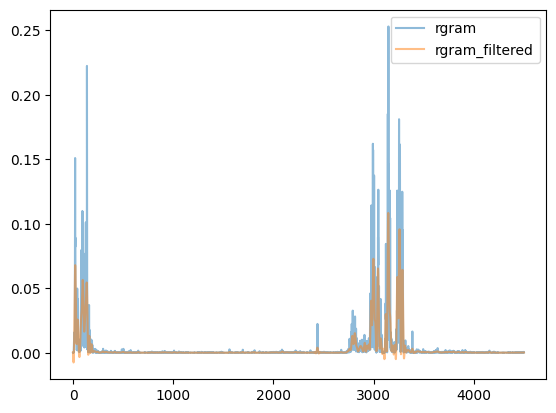

In [16]:
# 画出滤波前后的rgram的第n行数据
n = 2550
plt.plot(rgram[n, :], alpha=0.5)
plt.plot(rgram_temp[n, :], alpha=0.5)
# legend
plt.legend(["rgram", "rgram_filtered"])

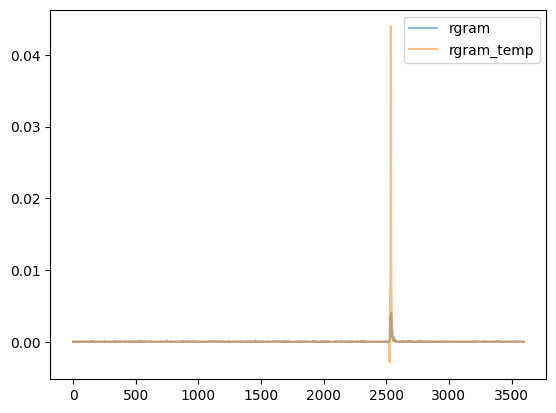

In [17]:
# 画出滤波前后的第n列数据
n = 250
plt.plot(rgram[:, n], alpha=0.5)
plt.plot(rgram_temp[:, n], alpha=0.5)
# legend
plt.legend(["rgram", "rgram_temp"])

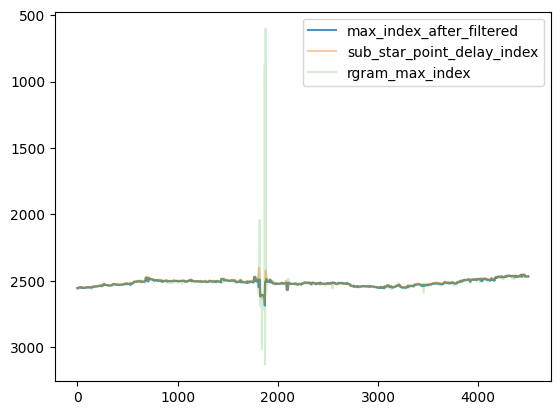

In [18]:
# 求出每一列rgram_temp的最大值的索引
rgram_temp_max_index = np.argmax(rgram_temp, axis=0)
rgram_max_index = np.argmax(rgram, axis=0)
# 画出rgram_temp_max_index
plt.plot(rgram_temp_max_index,alpha=0.8)
# 画出sub_star_point_delay_index
plt.plot(sub_star_point_delay_index,alpha=0.4)
# 画出rgram_max_index
plt.plot(rgram_max_index,alpha=0.2)
# 反转y轴
plt.gca().invert_yaxis()
# y轴只显示2000-3000
# plt.ylim(2300,2500)
# legend
plt.legend(["max_index_after_filtered", "sub_star_point_delay_index", "rgram_max_index"])

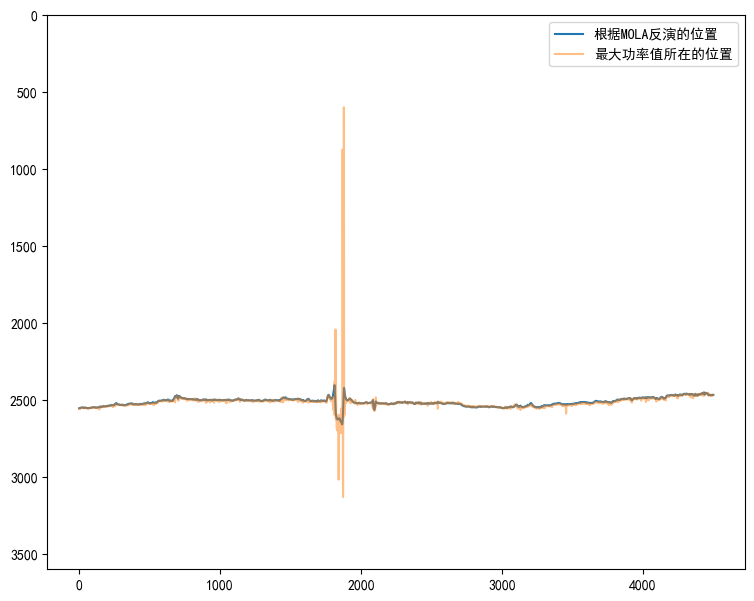

In [19]:
# matplot 支持显示中文
plt.rcParams["font.sans-serif"] = ["SimHei"]

# 设置图像尺寸
x_size = rgram.shape[1]/500
y_size = rgram.shape[0]/500
plt.figure(figsize=(x_size,y_size))
# 画出sub_star_point_delay_index
plt.plot(sub_star_point_delay_index,alpha=1)
# 画出rgram_max_index
plt.plot(rgram_max_index,alpha=0.5)
# y轴限制为2000-3000
plt.ylim(0,3600)
# 反转y轴
plt.gca().invert_yaxis()
# legend
plt.legend(["根据MOLA反演的位置", "最大功率值所在的位置"])

plt.savefig("原始位置.png")

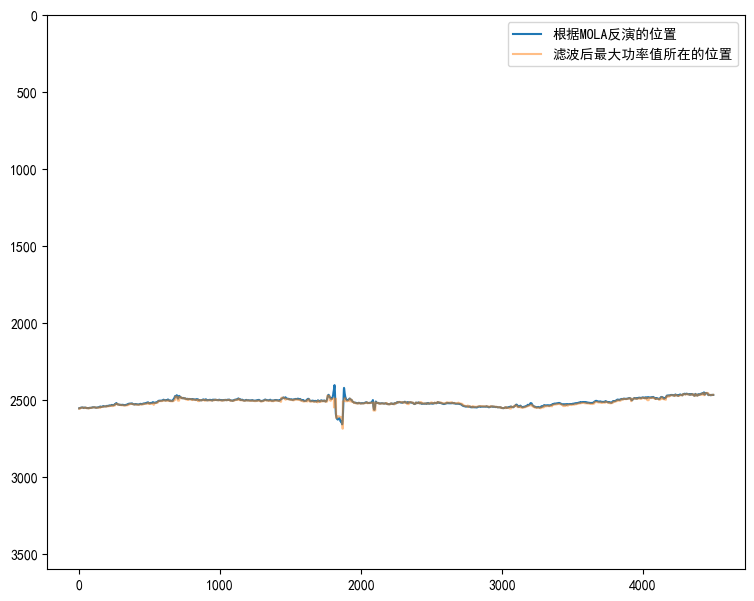

In [20]:
plt.figure(figsize=(x_size,y_size))
# 画出sub_star_point_delay_index
plt.plot(sub_star_point_delay_index,alpha=1)
# 画出rgram_max_index
plt.plot(rgram_temp_max_index,alpha=0.5)
# y轴限制为2000-3000
plt.ylim(0,3600)
# 反转y轴
plt.gca().invert_yaxis()
# legend
plt.legend(["根据MOLA反演的位置", "滤波后最大功率值所在的位置"])
plt.savefig("滤波后位置.png")

18666

C:\ProgramData\Anaconda3\envs\py_3_9_10\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


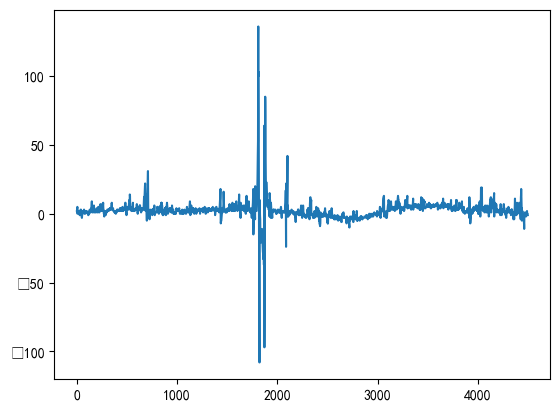

In [21]:
# 画出rgram_temp_max_index和sub_star_point_delay_index的差值
difference_index = rgram_temp_max_index - sub_star_point_delay_index
plt.plot(difference_index)
np.sum(np.abs(difference_index))

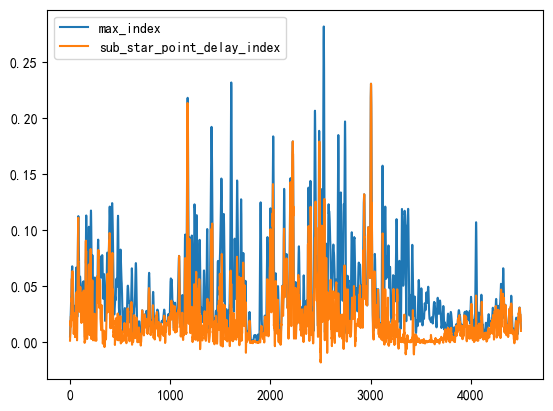

In [22]:
# 画出rgram_temp_max_index索引处rgram_temp的值
plt.plot(rgram_temp[rgram_temp_max_index, np.arange(rgram_temp.shape[1])])
# 画出sub_star_point_delay_index索引处rgram_temp的值
plt.plot(rgram_temp[sub_star_point_delay_index, np.arange(rgram_temp.shape[1])])
# legend
plt.legend(["max_index", "sub_star_point_delay_index"])

In [23]:
temp_data = rgram_temp[rgram_temp_max_index, np.arange(rgram_temp.shape[1])]
# 用pandas desc temp_data
import pandas as pd

pd.Series(temp_data).describe()

count    4500.000000
mean        0.047044
std         0.039018
min         0.000506
25%         0.019458
50%         0.034382
75%         0.062821
max         0.281597
dtype: float64

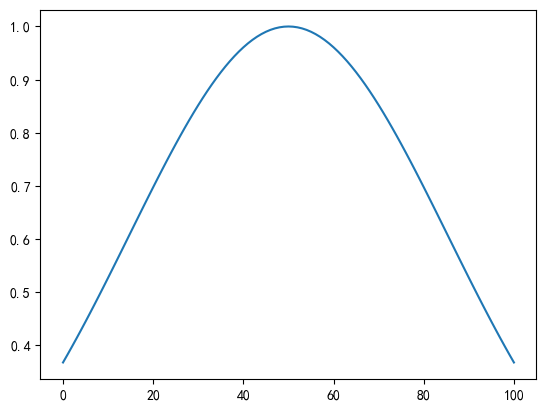

In [24]:
from scipy.optimize import curve_fit

# 加权线性最小二乘法的权重函数
def gauss_weight(x, loc, scale):
    return np.exp(-((x - loc) / scale) ** 2)
# 窗口大小
window_size = 50
window_length = window_size * 2 + 1
# weight
weight = gauss_weight(np.arange(window_length), window_size, window_size)
plt.plot(weight)
# 定义二次多项式
def quadratic_func(x, a1, a2, a3):
    return a1 * x ** 2 + a2 * x + a3
# 定义三次多项式
def cubic_func(x, a1, a2, a3, a4):
    return a1 * x ** 3 + a2 * x ** 2 + a3 * x + a4

In [25]:
print(np.argmax(weight))
print(weight.shape)

50
(101,)


100%|██████████| 4500/4500 [00:01<00:00, 3464.06it/s]


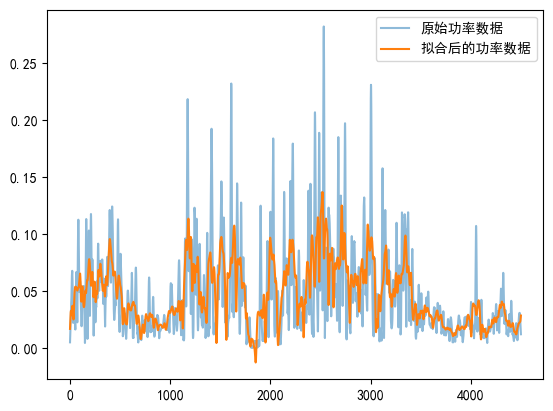

In [26]:
power_origin = rgram_temp[rgram_temp_max_index, np.arange(rgram_temp.shape[1])]
power = np.zeros(power_origin.shape)

for i in tqdm(range(rgram_temp.shape[1])):
    start = max(0, i - window_size)
    end = min(rgram_temp.shape[1], i + window_size + 1)
    
    # 切割power
    power_temp = power_origin[start:end]
    # 切割weight
    if start == 0:
        weight_temp = weight[weight.shape[0] - power_temp.shape[0] :]
    elif end == rgram_temp.shape[1]:
        weight_temp = weight[: power_temp.shape[0]]
    else:
        weight_temp = weight
    # 加权线性最小二乘法
    popt, pcov = curve_fit(
        quadratic_func, np.arange(power_temp.shape[0]), power_temp, sigma=weight_temp
    )
    # 求出拟合后对应i处的值
    if start == 0:
        power[i] = quadratic_func(power_temp.shape[0] - window_size - 1, *popt)
    else:
        power[i] = quadratic_func(window_size, *popt)
    
# 画出power
plt.plot(power_origin,alpha=0.5)
plt.plot(power)
# legend
plt.legend(["原始功率数据", "拟合后的功率数据"])
# 保存
plt.savefig("拟合后的功率数据.png")

In [27]:
pd.Series(power).describe()

count    4500.000000
mean        0.047021
std         0.026406
min        -0.012287
25%         0.025516
50%         0.040864
75%         0.066083
max         0.136775
dtype: float64

In [28]:
# 对于delay_index，delay_index[i,:]等于sub_star_point_delay_index[i]的为true，否则为false
mask = delay_index == sub_star_point_delay_index[:, np.newaxis]
# 存储每个维度mask为true的个数
mask_sum = np.sum(mask, axis=1)
# 画图
# plt.plot(mask_sum)

In [29]:
# 根据mask提取相同维度的area和incident_angle,true的为原值，false的为np.nan
sub_star_point_area = np.where(mask, area, np.nan)
sub_star_point_incident_angle = np.where(mask, incident_angle, np.nan)
sub_star_point_area.shape

(4500, 12000)

In [30]:
sub_star_point_area_sum = np.zeros(sub_star_point_area.shape[0])
for i in range(sub_star_point_area.shape[0]):
    # 去除nan值
    temp_incident_angle = sub_star_point_incident_angle[i][~np.isnan(sub_star_point_incident_angle[i])]
    temp_area = sub_star_point_area[i][~np.isnan(sub_star_point_area[i])]
    # 计算面积之和
    sub_star_point_area_sum[i] = np.sum(temp_area * np.cos(temp_incident_angle))
# 画图
# plt.plot(sub_star_point_area_sum)
# describe sub_star_point_area_sum
# pd.Series(sub_star_point_area_sum).describe()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_37500\1214967649.py:11: RuntimeWarning: divide by zero encountered in divide
  power / power_base * area_base / (H_base ** 2) * (r_base ** 2) / sub_star_point_area_sum * (_distance ** 2))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37500\1214967649.py:10: RuntimeWarning: invalid value encountered in sqrt
  r_point = np.sqrt(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37500\1214967649.py:12: RuntimeWarning: invalid value encountered in divide
  epsilon_point = ((1 + abs(r_point)) / (1 - abs(r_point))) ** 2


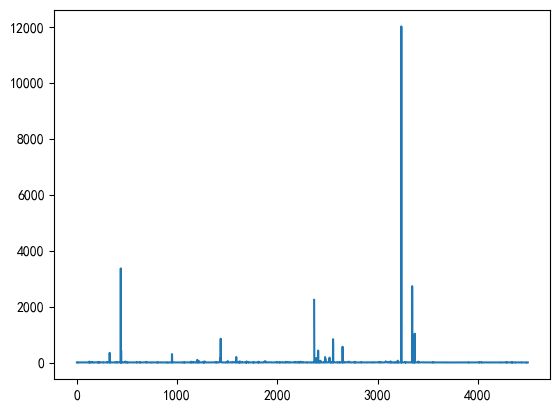

In [31]:
# 以第几个点为基准
point_num = 2000
power_base = power[point_num]
# 假设第一个点的介电常数为3
epsilon_base = 3
# 根据sqrt(epsilon) = (1+abs(r)) / (1-abs(r))计算反射系数
r_base = (np.sqrt(epsilon_base) - 1) / (np.sqrt(epsilon_base) + 1)
H_base = _distance[point_num]
area_base = sub_star_point_area_sum[point_num]
r_point = np.sqrt(
    power / power_base * area_base / (H_base ** 2) * (r_base ** 2) / sub_star_point_area_sum * (_distance ** 2))
epsilon_point = ((1 + abs(r_point)) / (1 - abs(r_point))) ** 2
# 画图
import matplotlib.pyplot as plt
# 去除异常值
# epsilon_point[epsilon_point > 10] = np.nan

plt.plot(epsilon_point)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_37500\713571036.py:10: RuntimeWarning: invalid value encountered in sqrt
  r_point = np.sqrt(


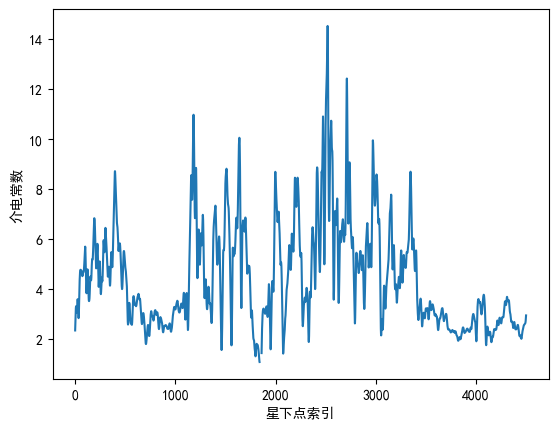

In [97]:
# 以第几个点为基准
point_num = 3700
power_base = power[point_num]
# 假设第十个点的介电常数为3
epsilon_base = 3
# 根据sqrt(epsilon) = (1+abs(r)) / (1-abs(r))计算反射系数
r_base = (np.sqrt(epsilon_base) - 1) / (np.sqrt(epsilon_base) + 1)
H_base = _distance[point_num]
area_base = 1
r_point = np.sqrt(
    power / power_base * area_base / (H_base ** 2) * (r_base ** 2) / 1 * (_distance ** 2))
epsilon_point = ((1 + abs(r_point)) / (1 - abs(r_point))) ** 2
# 画图
import matplotlib.pyplot as plt

plt.plot(epsilon_point)
# 横轴为点的索引，纵轴为介电常数
plt.xlabel("星下点索引")
plt.ylabel("介电常数")
# save
plt.savefig("epsilon_point.png")

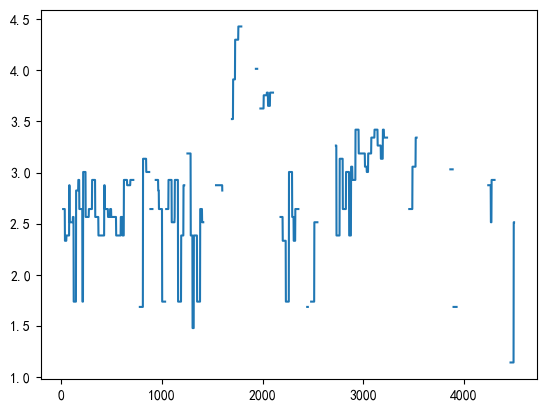

In [98]:
# sat_permittivity画图
plt.plot(sat_permittivity)

In [99]:
pd.Series(epsilon_point).describe()

count    4481.000000
mean        4.427560
std         2.076281
min         1.075075
25%         2.812730
50%         3.792297
75%         5.651017
max        14.532120
dtype: float64

### 画图1

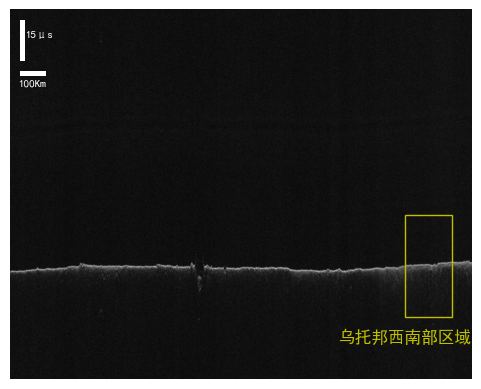

In [119]:
import matplotlib.patches as patches
plt.imshow(process_img_for_plot(rgram), cmap='gray')
plt.axis('off')

# 起点
start_point = 3850
width = 450

# y轴方向上的相邻两个点之间的距离为0.0375微秒，沿y轴画一个条状表示15微秒的长度
y_scale = patches.Rectangle((100, 100), 50, 15 / 0.0375, linewidth=1, edgecolor='none', facecolor='w')
plt.gca().add_patch(y_scale)
plt.text(150, 200, '15μs', fontsize=8, verticalalignment='top', horizontalalignment='left', color='w')
# x轴方向上的相邻两个点之间的距离为400m，沿x轴画一个条状表示100Km的长度
x_scale = patches.Rectangle((100, 600), 100000 / 400, 50, linewidth=1, edgecolor='none', facecolor='w')
plt.gca().add_patch(x_scale)
plt.text(80, 680, '100Km', fontsize=8, verticalalignment='top', horizontalalignment='left', color='w')
# 在图像中加一个黄色的框
plt.gca().add_patch(patches.Rectangle((start_point, 2000), width, 1000, linewidth=1, edgecolor='y', facecolor='none'))
# 在框的下面加一个文字
plt.text(3200, 3100, '乌托邦西南部区域', fontsize=12, verticalalignment='top', horizontalalignment='left', color='y')
plt.savefig('data/img/' + PRODUCT_ID + '_1.png', dpi=300, bbox_inches='tight')

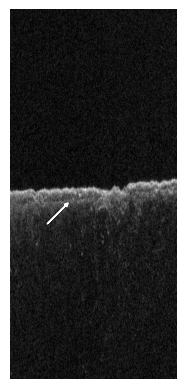

In [132]:
# 只显示框住的区域
plt.imshow(process_img_for_plot(rgram[2000:3000, start_point:start_point + width]), cmap='gray')
plt.axis('off')
# 加一个箭头
plt.arrow(100, 580, 50, -50, head_width=10, head_length=10, fc='w', ec='w')
plt.savefig('data/img/' + PRODUCT_ID + '_1_1.png', dpi=300, bbox_inches='tight')

In [121]:
# 太阳天顶角不符合设定的索引
SZA = geom[:,8]
SZA_not_suit = np.where(SZA < 100)
# 不符合的epsilon_point设为nan
epsilon_point[SZA_not_suit] = np.nan

In [122]:
# 每一个incident angle[i,:]中任何一个值大于pi/6，返回i的值
incident_angle_not_suit = np.where(incident_angle > np.pi / 6)
incident_angle_not_suit = np.array(incident_angle_not_suit[0])
incident_angle_not_suit = np.unique(incident_angle_not_suit)
# 不符合的epsilon_point设为nan
epsilon_point[incident_angle_not_suit] = np.nan

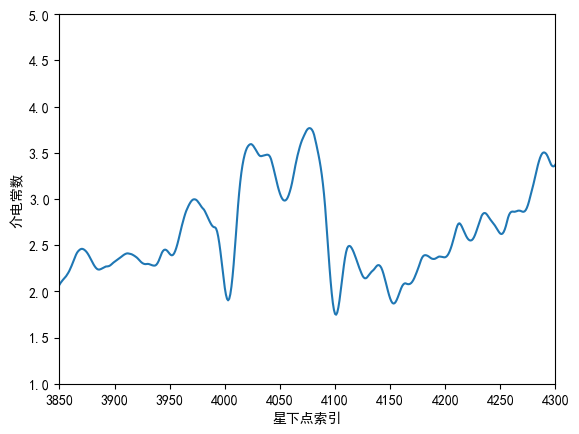

In [123]:
plt.plot(epsilon_point)
# 横轴为点的索引，纵轴为介电常数
plt.xlabel("星下点索引")
plt.ylabel("介电常数")
# 只显示2000-4000的x轴
plt.xlim(start_point, start_point + width)
# 只显示0-5的y轴
plt.ylim(1,5)
# save
plt.savefig('data/img/' + PRODUCT_ID + '_2.png', dpi=300, bbox_inches='tight')

count    450.000000
mean       2.642572
std        0.487361
min        1.746981
25%        2.289936
50%        2.459770
75%        2.933407
max        3.767082
dtype: float64

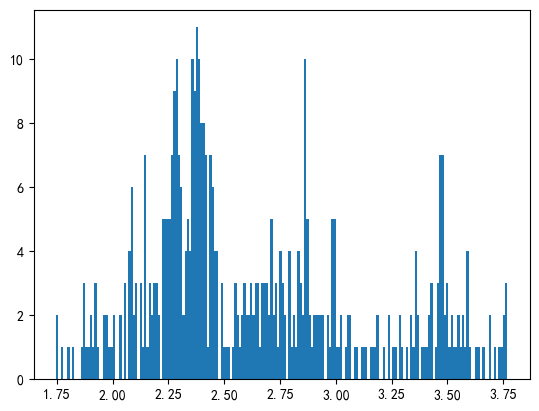

In [133]:
# 用matplot画箱图
epsilon_plot = epsilon_point[start_point:start_point + width]
epsilon_plot = epsilon_plot[~np.isnan(epsilon_plot)]
# plt.boxplot(epsilon_plot)
# # 不显示横轴坐标
# plt.xticks([])
# plt.plot()
plt.hist(epsilon_plot, bins=200)
# x轴限制为1-5
# plt.xlim(1,5)
# descripe epsilon_plot
pd.Series(epsilon_plot).describe()
# save
# plt.savefig('data/img/' + PRODUCT_ID + '_3.png', dpi=300, bbox_inches='tight')

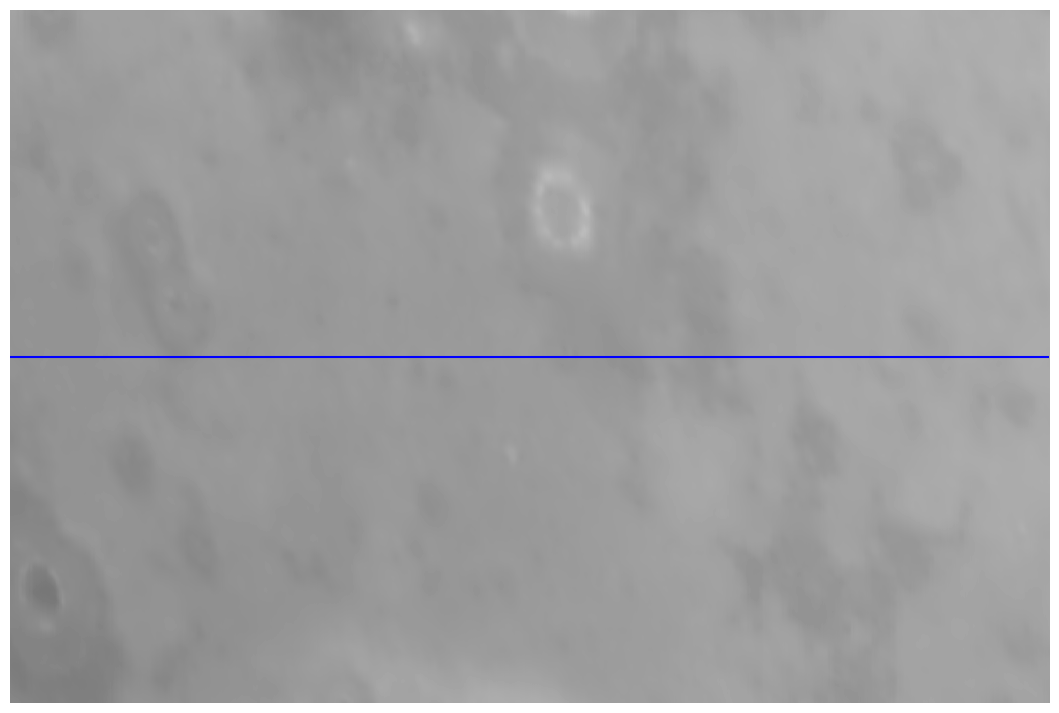

In [134]:
radius = sim_area_cartesian.reshape(point_count * 3001 * 3, 3)
radius = np.linalg.norm(radius, axis=1) - 3396190
radius = radius.reshape(point_count, 3001, 3)
# 使用transpose将3001和3的维度交换位置
transposed_radius = radius.transpose(0, 2, 1)

# 使用reshape变为(point_count * 3) x 3001的形状
reshaped_radius = transposed_radius.reshape(point_count * 3, 3001)

temp = delay.reshape(point_count, 3000, 4)
# 找到每个delay[i,:,:]中最小值的索引
# 在3000的方向上找到最小值的索引
min_indices = np.argmin(temp.reshape(point_count, -1), axis=1)
plt.figure(figsize=(16, 9))
plt.imshow(reshaped_radius.T, cmap='gray')
x = np.linspace(0, reshaped_radius.shape[0], point_count)
y = np.round(min_indices / 4)
# marker的形状可以参考 https://matplotlib.org/3.1.1/api/markers_api.html
# plt.scatter(x, y, marker=',', s=1, c='r')
# 画一条中线
plt.plot([0, reshaped_radius.shape[0]], [reshaped_radius.shape[1] / 2, reshaped_radius.shape[1] / 2], c='b')
# 调整y轴缩放
plt.gca().set_aspect(0.3)
plt.axis('off')
# x轴只显示2000-4000
plt.xlim(3*start_point, 3*(start_point + width))
# 保存
plt.savefig("data/img/" + PRODUCT_ID + "_4.png", dpi=300, bbox_inches='tight')